In [220]:
import shap
import numpy as np
from skimage.segmentation import slic
import keras
from keras.models import load_model
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
import sys
sys.path.append('../python')
from util import *
from PIL import Image

In [221]:
vgg_model = load_model("../models/d-logmelspectrogram_40_25_10_m-gg4_s-3/bag_0_model.h5")

In [222]:
resnet_model = load_model("../models/d-logmelspectrogram_40_25_10_m-resnet_s-34/bag_0_model.h5")

In [223]:
df, test_df, X, y, X_test = prepare_data(dataset = 'logmelspectrogram_40_25_10')

======= loading data =======


In [224]:
df.head()

,idx,filename,label
58479,58479,d1a17cbe_nohash_0.wav,three
53717,53717,bd2db1a5_nohash_0.wav,sheila
59601,59601,6adb8ad9_nohash_0.wav,tree
836,836,5e1b34a6_nohash_1.wav,up
32053,32053,7a5530c9_nohash_1.wav,dog


In [225]:
df.iloc[67101, :]

idx                          6648
filename    ced835d3_nohash_3.wav
label                          go
Name: 6648, dtype: object

In [226]:
sample = X[67101]
img = Image.fromarray(sample, mode='LA')

In [227]:
sample.shape

(101, 40)

In [228]:
full_num_label_mapping[vgg_model.predict(sample[np.newaxis,:,:]).argmax()]

'go'

In [229]:
full_num_label_mapping[resnet_model.predict(sample[np.newaxis,:,:]).argmax()]

'go'

In [251]:
num_masks = 200
segments_slic = slic(sample.reshape(101,40,1), n_segments=num_masks, compactness=30, sigma=3)

In [252]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out[:,:,:,0]

def f(z):
    return model.predict(mask_image(z, segments_slic, sample[:,:,np.newaxis]))

In [253]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

In [267]:
model = vgg_model
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,num_masks)))
shap_values = explainer.shap_values(np.ones((1,num_masks)), nsamples=5000) # runs VGG16 1000 times
# get the top predictions from the model
preds = model.predict(sample[np.newaxis,:,:])
top_preds = np.argsort(-preds)
ordered_labels = [full_num_label_mapping[i] for i in top_preds[0]]

100%|██████████| 1/1 [00:10<00:00, 10.58s/it]


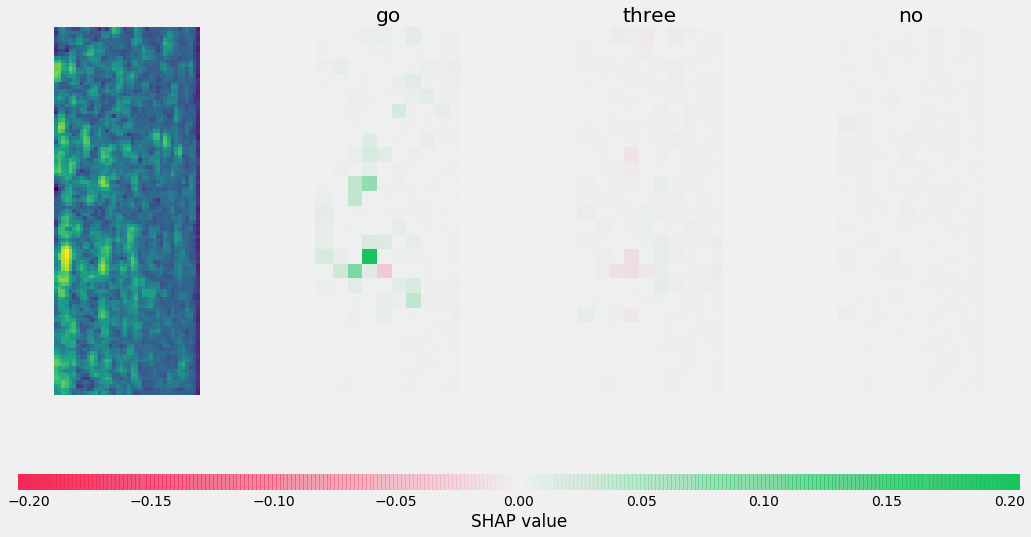

In [268]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,9))
inds = top_preds[0]
axes[0].imshow(sample)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(ordered_labels[i])
    axes[i+1].imshow(sample, alpha=0.01)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

In [269]:
model = resnet_model
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,num_masks)))
shap_values = explainer.shap_values(np.ones((1,num_masks)), nsamples=5000) # runs VGG16 1000 times
# get the top predictions from the model
preds = model.predict(sample[np.newaxis,:,:])
top_preds = np.argsort(-preds)
ordered_labels = [full_num_label_mapping[i] for i in top_preds[0]]

100%|██████████| 1/1 [00:12<00:00, 12.67s/it]


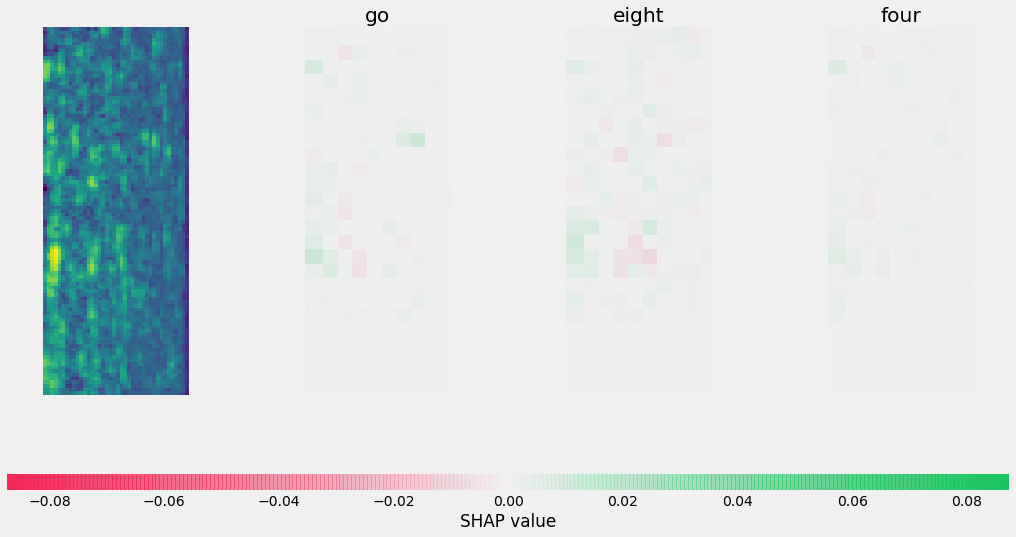

In [270]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 9))
inds = top_preds[0]
axes[0].imshow(sample)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(ordered_labels[i])
    axes[i+1].imshow(sample, alpha=0.01)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()